In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.linear_model import LinearRegression

from tqdm import tqdm_notebook as tqdm

## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [3]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [4]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

## Loading and adding in extra previous indicies

In [8]:
extra = feather.read_dataframe("../data_files/B/once/75days/se_prev_next.feather")
extra = extra.set_index(extra.columns[0])

In [14]:
se.loc[3920372]

id                                          170_159_3
date                              2018-12-16 00:00:00
stopCode                                 1290DOB21067
aimedArrival                      2018-12-16 10:24:00
aimedDeparture                    2018-12-16 10:24:00
actualArrival                     2018-12-16 10:27:59
actualDeparture                   2018-12-16 10:28:04
vehicle                                           127
workid                                      170_159_3
patternId                                     170_172
publicName                                          4
scheduledStart                                  36120
prev_stopCode                            1290BOA05882
prev_aimedArrival                 2018-12-16 10:24:00
prev_aimedDeparture               2018-12-16 10:24:00
prev_actualArrival                2018-12-16 10:27:15
prev_actualDeparture              2018-12-16 10:27:36
timingPoint                                         0
prev_timingPoint            

## Adding in a few more medians... why not

Starting by making some more medians to compare

In [9]:
se['weekend'] = (se['arrival_day'] > 4)

se['weekend'] = se['weekend'].astype(bool)

In [10]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

In [11]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [12]:

median_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [13]:
segment_code_and_hour_and_daytype_groups = None
median_durations_by_segment_code_and_hour_and_daytype = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None


In [14]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min

In [ ]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_", 
            "prev_stop_", 
            "next_stop_",
            "road"])

## Build chains

- Make two new columns 'predict_segment', 'predict_dwell', 'actual_segment' and 'actual_dwell'
- For each event go back through the ones we have the index for and start to build an array of predictions and actuals
- Build a new data structure which has 'predict', 'actual', 'destination_index' and 'hops'
- Graph and analise the predict vs actual and the percentage accuracy vs time and number of hops

In [16]:
se['predict_segment'] = se['median_durations_by_segment_code_and_hour_and_daytype']
# se['predict_dwell'] = se['median_prev_dwell_by_segment_code_and_hour_and_daytype']
se['predict_dwell'] = 5


In [17]:
se['actual_segment'] = se['segment_duration']
se['actual_dwell'] = se['dwell_duration_prev']

In [18]:
se['predict_list'] = np.empty((se.shape[0], 0)).tolist()
se['actual_list'] = np.empty((se.shape[0], 0)).tolist()

In [27]:
predict_array = np.empty((se.shape[0],16))
predict_array[:] = np.nan

actual_array = np.empty((se.shape[0],16))
actual_array[:] = np.nan

In [23]:
predict_array[:, 0] = se['predict_segment'].values
predict_array[:, 1] = se['predict_dwell'].values
actual_array[:,0] = se['actual_segment'].values
actual_array[:,1] = se['actual_dwell'].values

In [28]:
predict_array[:, 14] = se.loc[se['prev_event_index_7'], 'predict_segment'].values
predict_array[:, 15] = se.loc[se['prev_event_index_7'], 'predict_dwell'].values
actual_array[:,14] = se.loc[se['prev_event_index_7'], 'actual_segment'].values
actual_array[:,15] = se.loc[se['prev_event_index_7'], 'actual_dwell'].values

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [25]:
for i in range(1, 8):
    print(".", end="", flush=True)
    predict_array[:, i*2] = se.loc[se[f'prev_event_index_{i}'], 'predict_segment'].values
    predict_array[:, (i*2) + 1] = se.loc[se[f'prev_event_index_{i}'], 'predict_dwell'].values
    actual_array[:,i*2] = se.loc[se[f'prev_event_index_{i}'], 'actual_segment'].values
    actual_array[:,(i*2) + 1] = se.loc[se[f'prev_event_index_{i}'], 'actual_dwell'].values

.......

IndexError: index 14 is out of bounds for axis 1 with size 14

In [26]:
predict_array_temp = predict_array
actual_array_temp = actual_array

In [30]:
predict_array[:, :14] = predict_array_temp
actual_array[:, :14] = actual_array_temp

In [34]:
predict_array_cum = np.cumsum(predict_array, axis=1)
actual_array_cum = np.cumsum(actual_array, axis=1)

In [74]:
predict_array_journey_cum = np.cumsum(predict_array[:, ::2], axis=1)
actual_array_journey_cum = np.cumsum(actual_array[:, ::2], axis=1)

In [86]:
predict_array_dwell_cum = np.cumsum(predict_array[:, 1::2], axis=1)
actual_array_dwell_cum = np.cumsum(actual_array[:, 1::2], axis=1)

## Eyeball some results

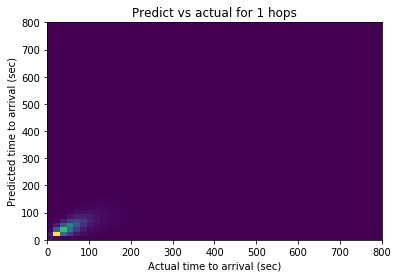

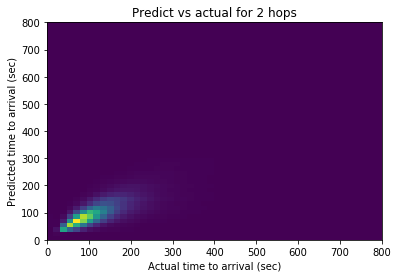

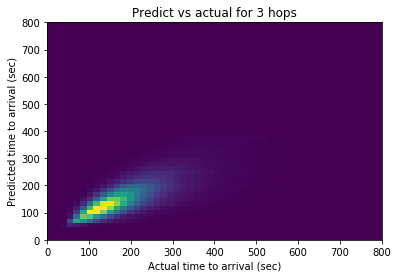

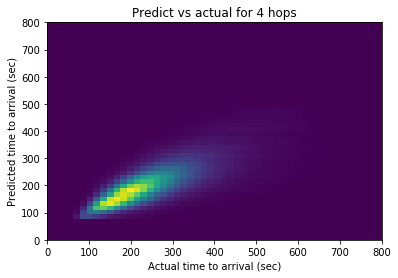

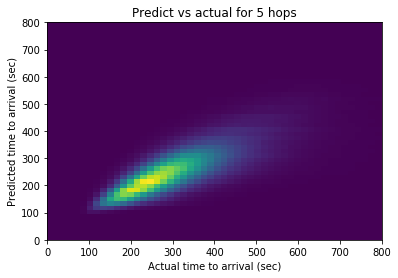

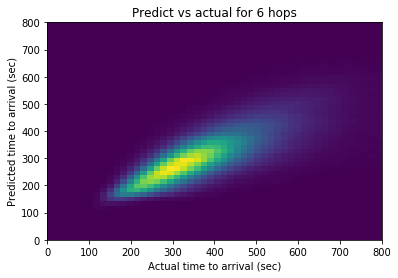

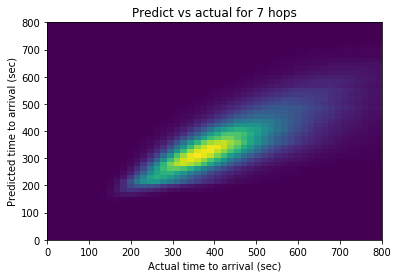

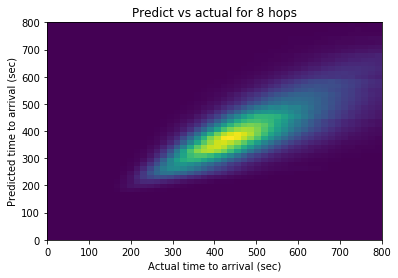

In [54]:
for i in range(8):
    
    plt.hist2d(actual_array_cum[:,i*2 + 1], predict_array_cum[:,i*2 + 1], bins=[50,50], range=[[0,800], [0,800]]);
    plt.title(f"Predict vs actual for {i+1} hops")
    plt.xlabel("Actual time to arrival (sec)")
    plt.ylabel("Predicted time to arrival (sec)")
    plt.show()

In [161]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    pass_percent = pass_count/np.count_nonzero(~np.isnan(actual)) * 100
    
    return pass_percent

In [162]:
def make_accuracy_matrix(predict, actual, max_threshold = 50):
    
    rows = int(max_threshold/10)

    accuracies_table = np.empty((rows, predict.shape[1]))

    for i in range(predict.shape[1]):
        print(".", end="", flush=True)
        for j in range(1, rows+1):
            accuracy = percent_in_x_percent(predict[:,i], actual[:,i], j * 10)
    #         print(accuracy)
            accuracies_table[j-1,i] = accuracy

    return accuracies_table

In [163]:
# max_a = np.nanmax(actual_array_journey_cum)/60

# actual_ints = np.array(actual_array_journey_cum/60).astype(int)

# for i in range(int(max_a)):
#     mask = (actual_ints == i)
#     print(percent_in_x_percent(predict_array_journey_cum[mask], actual_array_journey_cum[mask], 20))


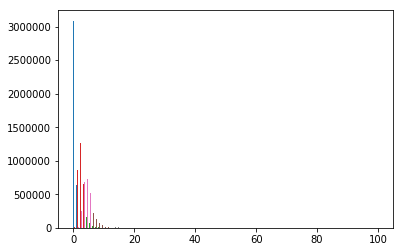

In [164]:
plt.hist(actual_ints, bins=100, range=(0, 100));

In [173]:
def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy = percent_in_x_percent(predict[mask], actual[mask], j * 10)
    #         print(accuracy)
            accuracies_table[j-1,i] = accuracy

    return accuracies_table, frequency

In [174]:
def show_accuracy(predict, actual, title):
    results, _ = make_accuracy_matrix(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
    plt.legend()
    plt.xlabel("predictions")
    plt.ylabel("percentage within threshold")
    plt.title(title)
    plt.show()

In [179]:
def show_accuracy_minutes(predict, actual, title):
    results, frequency = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(frequency, label="frequency")
    ax2.legend()

   
    plt.show()

......................................................................................

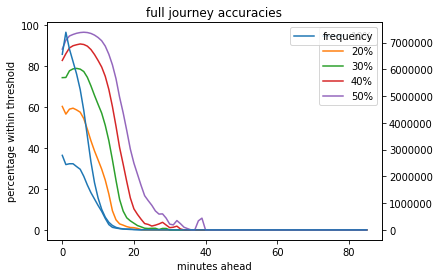

In [180]:
show_accuracy_minutes(predict_array_cum, actual_array_cum, "full journey accuracies")

........

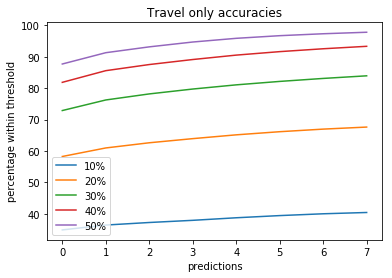

In [169]:
show_accuracy(predict_array_journey_cum, actual_array_journey_cum, "Travel only accuracies")

........

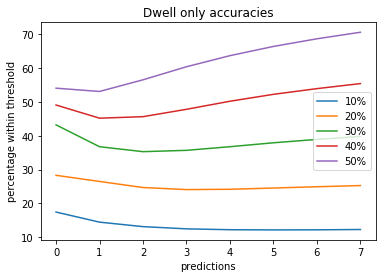

In [170]:
show_accuracy(predict_array_dwell_cum, actual_array_dwell_cum, "Dwell only accuracies")

In [171]:
percent_in_x_percent(np.array([1,np.nan,np.nan]), np.array([1,2,np.nan]), 10)

50.0